# Predictive Model: Data Injection and Visualization for Dutch TTF Natural Gas Futures
This notebook demonstrates how to handle missing days in the Dutch TTF Natural Gas Futures dataset using linear interpolation, and visualizes the results. The approach leverages daily high, low, and percentage change columns for more informed interpolation.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Load the TTF Training Data
Read the historical Dutch TTF Natural Gas Futures data and inspect the first few rows.

In [4]:
# The CSV was read as a single column due to semicolon delimiter. Let's fix that.
file_path = '../Data/Dutch TTF Natural Gas Futures Historical Data.csv'
df = pd.read_csv(file_path, delimiter=';')

# Split the single column into multiple columns
if df.shape[1] == 1:
    df = df.iloc[:, 0].str.split(',', expand=True)
    df.columns = ['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']

print('Columns:', df.columns.tolist())

# Now proceed with date parsing and sorting
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
else:
    raise ValueError('Date column not found in the dataset.')

if df.index.name != 'Date':
    df = df.set_index('Date')
df.head()

Columns: ['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']


/var/folders/py/tttdp81n4rj_y9mxm1f1br6r0000gn/T/ipykernel_48676/1028257424.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-01-02,22.475,22.28,22.55,22.145,0.02K,2.25%
2019-01-03,22.255,22.215,22.215,22.115,0.01K,-0.98%
2019-01-04,22.93,22.845,22.955,22.81,0.04K,3.03%
2019-01-07,21.53,21.91,21.91,21.47,0.04K,-6.11%
2019-01-08,22.09,22.165,22.165,22.165,0.01K,2.60%


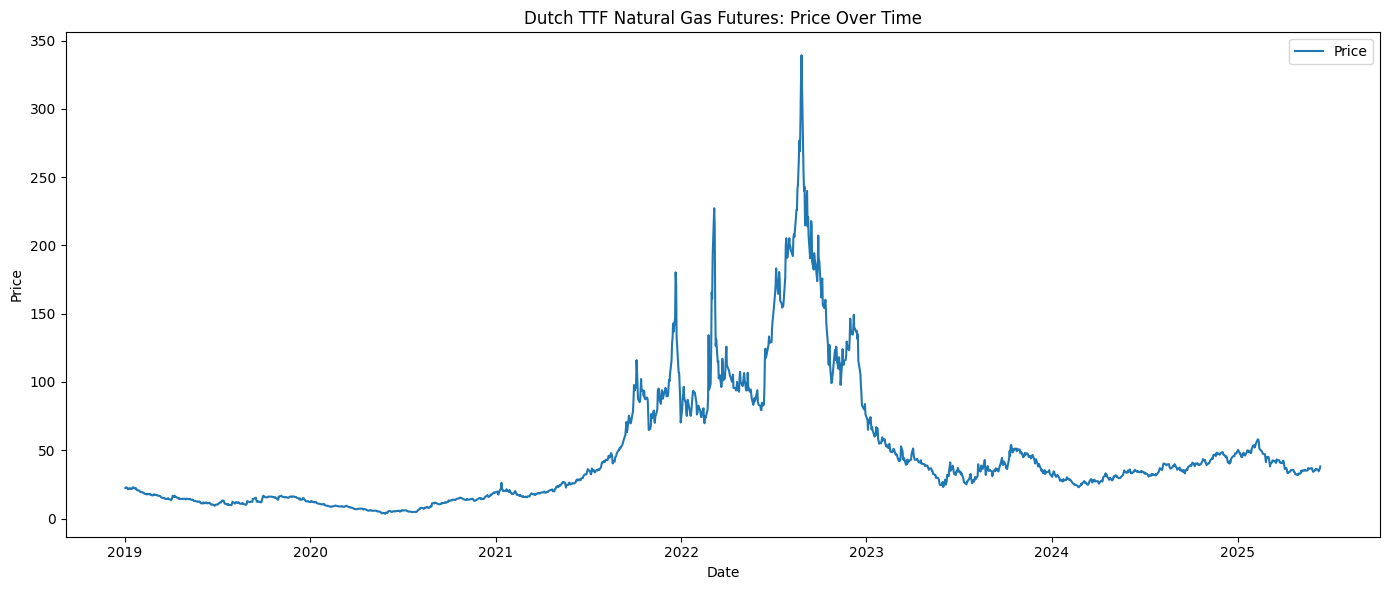

In [6]:
plt.figure(figsize=(14, 6))
plt.plot(df.index, pd.to_numeric(df['Price'], errors='coerce'), label='Price')
plt.title('Dutch TTF Natural Gas Futures: Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

## Reindex to Include All Calendar Days
Reindex the DataFrame to include all days in the date range, so missing days are visible and can be interpolated.

In [7]:
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
df_full = df.reindex(full_range)
df_full.head(10)

,Price,Open,High,Low,Vol.,Change %
2019-01-02,22.475,22.28,22.55,22.145,0.02K,2.25%
2019-01-03,22.255,22.215,22.215,22.115,0.01K,-0.98%
2019-01-04,22.93,22.845,22.955,22.81,0.04K,3.03%
2019-01-05,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-06,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-07,21.53,21.91,21.91,21.47,0.04K,-6.11%
2019-01-08,22.09,22.165,22.165,22.165,0.01K,2.60%
2019-01-09,21.72,22.515,22.515,21.745,0.02K,-1.67%
2019-01-10,21.675,21.705,21.705,21.705,0.01K,-0.21%
2019-01-11,22.255,22.39,22.39,22.085,0.08K,2.68%


In [8]:
# Fill missing dates in df_full using linear interpolation, but adjust using High, Low, and Change %
# We'll interpolate High, Low, and Price, then use Change % to refine the interpolated Price

# Convert columns to numeric where possible
for col_name in ['Price', 'High', 'Low']:
    df_full[col_name] = pd.to_numeric(df_full[col_name], errors='coerce')

# Convert 'Change %' to float (remove % sign)
df_full['Change %'] = df_full['Change %'].str.replace('%', '', regex=False)
df_full['Change %'] = pd.to_numeric(df_full['Change %'], errors='coerce')

# Interpolate High, Low, and Price
for col_name in ['High', 'Low', 'Price']:
    df_full[col_name] = df_full[col_name].interpolate(method='linear')

# Now, for missing Price values, use previous day's price and 'Change %' if available
for idx in df_full.index:
    if pd.isna(df_full.at[idx, 'Price']):
        prev_idx = idx - pd.Timedelta(days=1)
        if prev_idx in df_full.index and not pd.isna(df_full.at[prev_idx, 'Price']) and not pd.isna(df_full.at[idx, 'Change %']):
            # Calculate price based on previous price and change %
            df_full.at[idx, 'Price'] = df_full.at[prev_idx, 'Price'] * (1 + df_full.at[idx, 'Change %'] / 100)

# If any Price values are still missing, fallback to linear interpolation
df_full['Price'] = df_full['Price'].interpolate(method='linear')

# Optionally, fill High/Low with Price if still missing
for col_name in ['High', 'Low']:
    df_full[col_name] = df_full[col_name].fillna(df_full['Price'])

df_full.head(10)

,Price,Open,High,Low,Vol.,Change %
2019-01-02,22.475000,22.28,22.550000,22.145000,0.02K,2.25
2019-01-03,22.255000,22.215,22.215000,22.115000,0.01K,-0.98
2019-01-04,22.930000,22.845,22.955000,22.810000,0.04K,3.03
2019-01-05,22.463333,NaN,22.606667,22.363333,NaN,NaN
2019-01-06,21.996667,NaN,22.258333,21.916667,NaN,NaN
2019-01-07,21.530000,21.91,21.910000,21.470000,0.04K,-6.11
2019-01-08,22.090000,22.165,22.165000,22.165000,0.01K,2.60
2019-01-09,21.720000,22.515,22.515000,21.745000,0.02K,-1.67
2019-01-10,21.675000,21.705,21.705000,21.705000,0.01K,-0.21
2019-01-11,22.255000,22.39,22.390000,22.085000,0.08K,2.68


In [9]:
# Fill missing 'Change %' values in df_full using the last available value (forward fill)
df_full['Change %'] = df_full['Change %'].fillna(method='ffill')
df_full.head(10)

# Make df_full global for access in other cells
globals()['df_full'] = df_full

/var/folders/py/tttdp81n4rj_y9mxm1f1br6r0000gn/T/ipykernel_29312/684266584.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_full['Change %'] = df_full['Change %'].fillna(method='ffill')


In [15]:
# Set forecast period: from 2025-06-13 to 2026-06-13 (inclusive)
forecast_start = pd.Timestamp('2025-06-13')
forecast_end = pd.Timestamp('2026-06-13')
forecast_periods = (forecast_end - forecast_start).days + 1  # inclusive

# Create future dataframe for the forecast period
future = prophet_model.make_future_dataframe(periods=forecast_periods, freq='D')
future = future[future['ds'] >= forecast_start]  # Only forecast from start date

# Predict
forecast = prophet_model.predict(future)

# Set index to match forecast_dates
forecast_dates = pd.date_range(start=forecast_start, end=forecast_end, freq='D')
forecast = forecast.set_index('ds').loc[forecast_dates]

# Display the forecasted prices
forecast[['yhat']].head(20)


,yhat
2025-06-13,36.157242
2025-06-14,36.731671
2025-06-15,37.325111
2025-06-16,37.925108
2025-06-17,39.022126
2025-06-18,39.928407
2025-06-19,40.638583
2025-06-20,40.351313
2025-06-21,40.891952
2025-06-22,41.412292


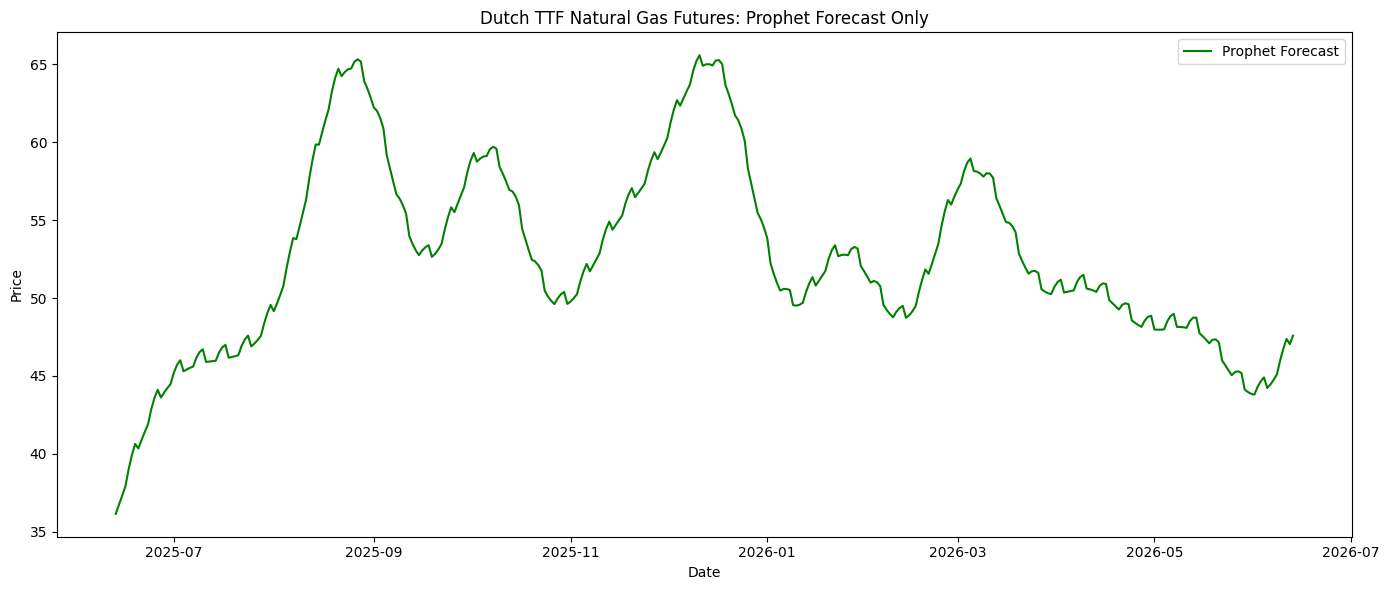

In [16]:
plt.figure(figsize=(14, 6))
plt.plot(forecast.index, forecast['yhat'], label='Prophet Forecast', color='green')
plt.title('Dutch TTF Natural Gas Futures: Prophet Forecast Only')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

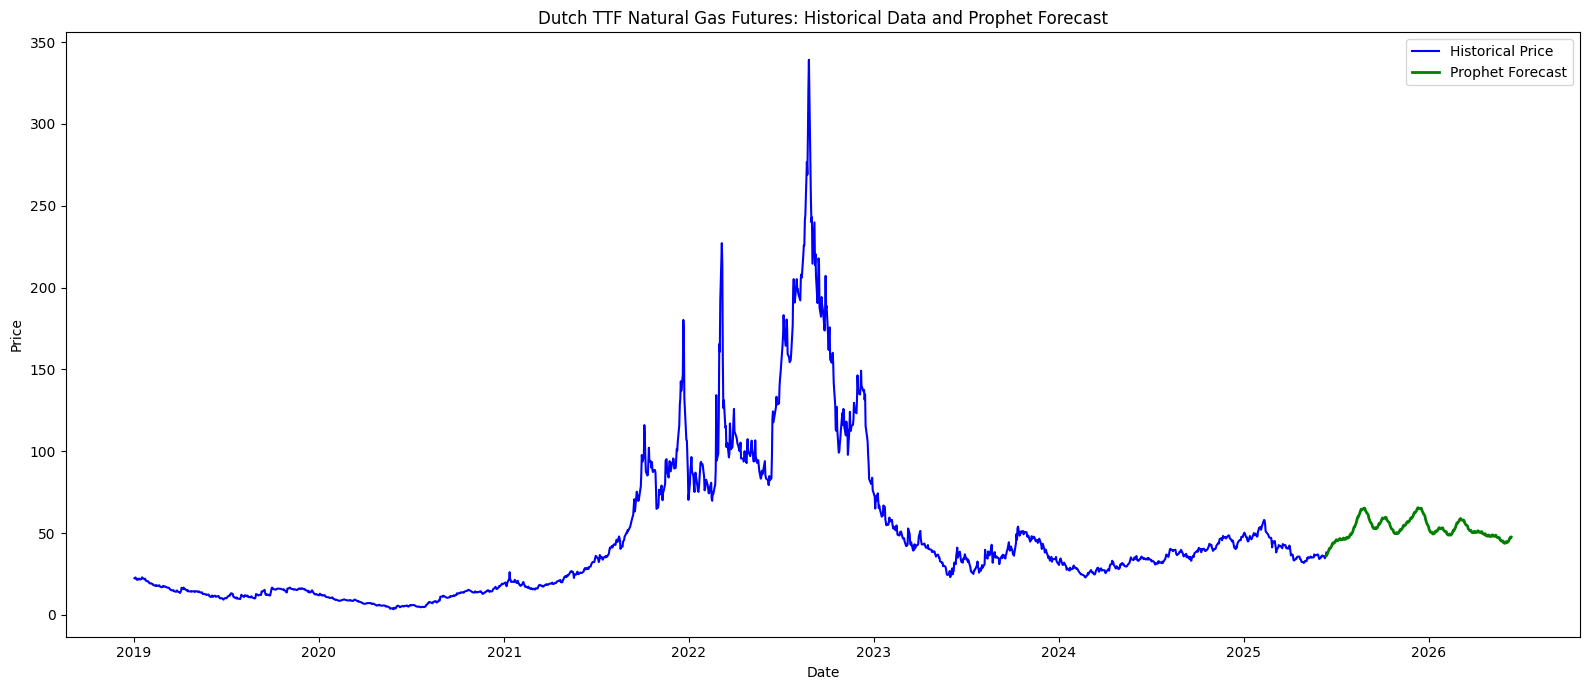

In [17]:
plt.figure(figsize=(16, 7))

# Plot historical data
plt.plot(df_full.index, df_full['Price'], label='Historical Price', color='blue', linewidth=1.5)

# Plot Prophet forecast
plt.plot(forecast.index, forecast['yhat'], label='Prophet Forecast', color='green', linewidth=2)

plt.title('Dutch TTF Natural Gas Futures: Historical Data and Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
# Fill 'Change %' for the forecasted period using predicted prices
# Ensure forecast_dates, forecast, and df_full are available

# Get the predicted prices as a Series
predicted_prices = forecast['yhat']

# Calculate daily percentage change for the forecasted period
predicted_change_pct = predicted_prices.pct_change() * 100

# Extend df_full to include all forecast dates if not already present
all_dates = df_full.index.union(forecast.index)
df_full = df_full.reindex(all_dates)

# Assign the predicted prices to the 'Price' column for the forecasted dates
df_full.loc[predicted_prices.index, 'Price'] = predicted_prices

# Assign the calculated change % to the corresponding dates in df_full
df_full.loc[predicted_change_pct.index, 'Change %'] = predicted_change_pct

# Display the updated 'Change %' for the forecasted period
df_full.loc[forecast.index, ['Price', 'Change %']].head(10)

,Price,Change %
2025-06-13,36.157242,NaN
2025-06-14,36.731671,1.588698
2025-06-15,37.325111,1.615608
2025-06-16,37.925108,1.607490
2025-06-17,39.022126,2.892590
2025-06-18,39.928407,2.322479
2025-06-19,40.638583,1.778623
2025-06-20,40.351313,-0.706890
2025-06-21,40.891952,1.339831
2025-06-22,41.412292,1.272474


In [21]:
df_full.to_csv('TTF_daily_prediction.csv')